In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import io
import os

# Chapter1. 평균필터

# 1.1. 평균의 재귀식
배치식(batch expression)이란, 데이터를 모두 모아 한꺼번에 계산하는 형태이다. 새로운 데이터가 들어오면 처음부터 다시 계산해야 하므로 이전 결괏값을 쓸 수 없다.

배치식으로 구현한 평균은 아래와 같다.

$\bar{x_k} = \cfrac{x_1 + x_2 + \cdots + x_k}{k}$

재귀식(recursive expression)은 이전 결과를 다시 활용하는 형태로, 계산의 효율이 더 낫다. 이전 결괏값과 추가된 데이터, 데이터 개수 등만 저장하면 되므로 메모리 저장 공간 효율도 높다.

재귀식으로 구현한 평균은 아래와 같으며, 이를 두고 평균 필터(average filter)라고 한다.

$\begin{equation}
  \begin{aligned}
    \bar{x}_k & = \cfrac{k-1}{k} \bar{x}_{k-1} \cfrac{1}{k} x_k \\
      & = \alpha \bar{x}_{k+1} + (1 - \alpha)x_k \quad \left( \alpha = \cfrac{k-1}{k} \right)
  \end{aligned}
\end{equation}$

평균 필터는 센서 초기화에도 이용된다. 가령 영점을 맞출 때 초기값들을 모아 평균을 내 영점으로 사용한다.


In [3]:
### 평균 필터 함수

prev_avg = 0
k = 0

def AverageFilter(x):
    """
    (param)     x : 새로 들어온 데이터
    (return)    avg : 평균값
    """
    global prev_avg, k

    k += 1    
    alpha = (k - 1) / k
    avg = alpha * prev_avg + (1 - alpha) * x
    prev_avg = avg
    
    return avg

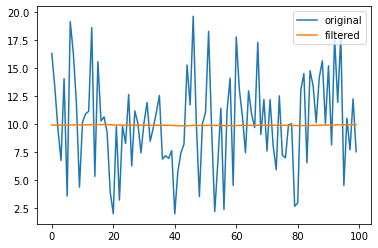

In [15]:
x_origin = np.random.normal(10, 4, 100)
    # 평균이 10이고 표준편차가 4인 100개의 난수 생성
x_filtered = [AverageFilter(x) for x in x_origin]

plt.plot(x_origin, label='original')
plt.plot(x_filtered, label='filtered')
plt.legend()

plt.savefig('output/part1-chapter1-average_filter.png')
plt.show()

# Chapter2. 이동평균 필터
## 2.1. 이동평균의 재귀식

측정하는 물리량이 시간에 따라 변할 경우, 평균은 데이터의 동적 움직임을 고려하지 않으므로 데이터 수집 시작 혹은 현재로부터 오래 전의 데이터부터 평균을 취하는 것은 적절하지 않다.

이동평균(moving average)는 잡음을 없애면서 시스템의 동적인 변화를 고려하기 위해 고안되었다. N개의 최근 측정치를 평균하는 방법으로, 새로운 데이터가 입력된다면 이전 데이터는 버린다.

이동 평균의 배치식은 아래와 같다.

$\bar{x}_k = \cfrac{x_{k - n + 1} + x_{k - n + 2} + \cdots + x_k}{n}$

여기서 말하는 $\bar{x}_k$은 k개 데이터의 평균이 아니라, '$(k - n + 1)$번째부터 $k$번째까지 $n$개 데이터의 평균'을 말함에 주의한다.

재귀식으로 바꾸면 그것이 이동평균 필터(moving average filter)가 되고, 식은 아래와 같다.

$\bar{x}_k = \bar{x}_{k-1} + \cfrac{x_k - x_{k-n}}{n}$

다만 이동평균필터는 재귀식을 사용하는 이점이 덜하다. 어차피 최근 n개의 데이터가 저장되어야 함은 똑같다. n의 수가 크지 않다면 이전 데이터를 저장했다가 일반적 방법으로 평균을 구해도 나쁘지 않다.

In [11]:
### 이동평균필터
def MovingAverageFilter(prev_data, n, x):
    """
    (param)     prev_data : 이전 데이터가 저장된 배열
                n : 이동평균필터 큐의 크기
                x : 새로 들어온 데이터
    (return)    avg : 이동평균
    """

    # n개의 데이터가 모이기 전까지는 무시하는 버전
    # if len(prev_data) < n:
    #     return 0

    if len(prev_data) >= n:
        prev_data.pop(0)
    prev_data.append(x)

    return sum(prev_data) / len(prev_data)

In [5]:
### 데이터 로드
mat_file = io.loadmat('C:\\coding\\datasets\\kalman_filter\\2.MovAvgFilter\\SonarAlt.mat')

# print(mat_file)
sonar_data = np.array(mat_file['sonarAlt']).reshape(1501)
# print(sonar_data)

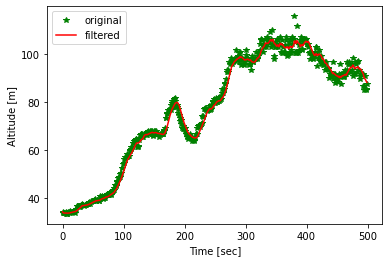

In [16]:
n_samples = 500
n = 10

x_filtered = []
prev_data = []

x_filtered = [MovingAverageFilter(prev_data, n, x) for x in sonar_data[:n_samples]]

time = np.arange(0, n_samples)
plt.plot(time, sonar_data[:n_samples], 'g*', label='original')
plt.plot(time, x_filtered, 'r-', label='filtered')
plt.legend()
plt.xlabel('Time [sec]')
plt.ylabel('Altitude [m]')

plt.savefig('output/part1-chapter2-moving_average_filter.png')
plt.show()

# chapter3. 저주파 통과 필터
저주파 통과 필터(low-pass filter)는 '저주파 필터'라고도 하며, 저주파 신호는 통과시키고 고주파 신호는 제거하는 필터이다. 저주파 신호를 측정하고 고주파 신호는 잡음으로서 제거할 때 주로 사용한다. 아래 내용은 1차(first order) 저주파 통과 필터이다.

## 3.1. 이동 평균의 한계
이동평균은 모든 데이터에 동일한 가중치($\cfrac{1}{n}$)을 부여하여, 가장 최근 데이터가 가장 오래된 데이터와 같은 비중(중요도)를 갖게 된다. 만약 시간에 따른 변화가 큰 데이터일 경우, 최신 측정값이 현재 정보를 더 잘 반영하므로 이전 측정값과 동일하게 취급하는 것은 안전성 및 안정성에 큰 영향을 미칠 수 있다.

## 3.2. 1차 저주파 통과 필터
오래된 데이터에는 낮은, 최근의 데이터에는 높은 가중치를 부여하기 위해, 1차 저주파 통과 필터를 알아보겠다. 1차 저주파 통과 필터는 '지수 가중(exponentially weighted) 이동평균 필터'라고도 한다. 오래된 데이터일수록 기하급수적으로 낮은 가중치를 부여하기 때문으로, 아래 식이 이 이름이 붙은 이유를 설명한다. $\alpha$는 $0 < \alpha < 1$의 범위를 갖는 상수이며, $\bar{x}_k$는 평균이 아닌 '추정값(estimated value)'라고 부른다.

$\bar{x}_k = \alpha \bar{x}_{k - 1} + (1-\alpha) x_k$

$\bar{x}_{k-1}$에 대한 식을 $\bar{x}_{k}$에 대입해보면 이전 측정치인 $\bar{x}_{k-1}$에는 $\alpha (1-\alpha)$가 계수로 붙게 됨을 알 수 있다. $\bar{x}_{k}$의 계수인 $\alpha$ 보다 작은 수치이다. 이와 같은 원리로, 이전 값일 수록 $\alpha^m (1-\alpha)$의 계수로 더더 낮은 계수를 갖게 된다. 그 말인 즉 더 낮은 가중치를 갖게 된다.

이때 결과 그래프에서도 볼 수 있듯이 $\alpha$가 클수록 잡음은 줄어들지만 지연(latency)가 늘어난다. 이전 추정치를 더 많이 반영하기 때문이다. 반대로 $\alpha$가 작을수록 잡음이 늘고 지연이 줄어든다. 새 측정치를 더 많이 반영하기 때문이다.

In [22]:
### 저주파 통과 필터

def LowPassFilter(alpha, prev, x):
    """
    (param) alpha : weight for previous estimation
            prev : previous estimation
            x : new data
    (return) estimation
    """
    return alpha * prev + (1 - alpha) * x

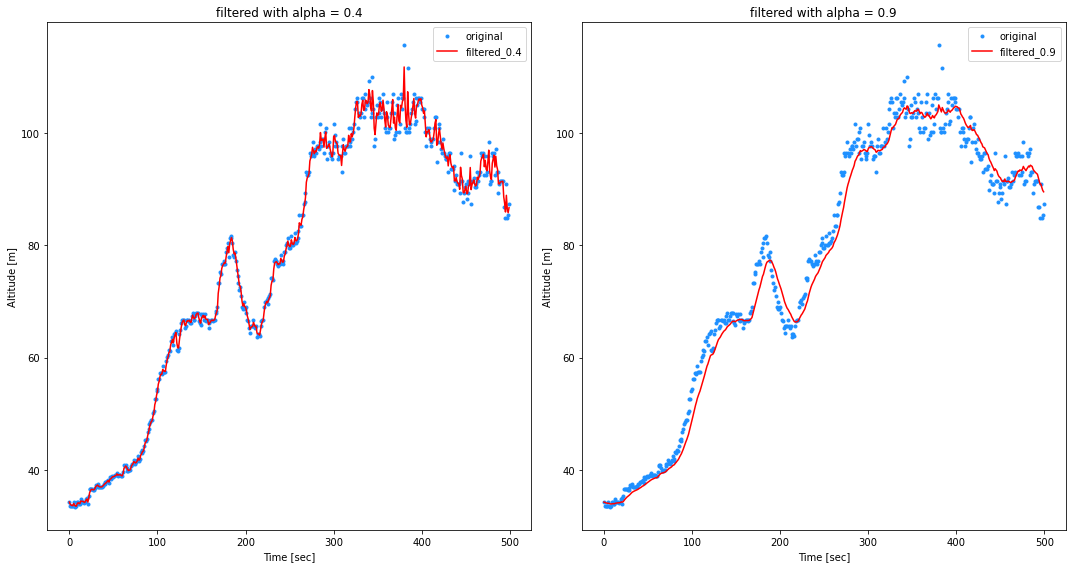

In [52]:
n_samples = 500
alpha = [0.4, 0.9]
x_filtered = np.zeros((2, n_samples))

plt.figure(figsize=(15, 8))

for i in range(len(alpha_arr)):
    prev = sonar_data[0]
    for j in range(n_samples):
        prev = LowPassFilter(alpha[i], prev, sonar_data[j])
        x_filtered[i][j] = prev
        
    plt.subplot(1, 2, i + 1)
    plt.title('filtered with alpha = '+str(alpha[i]))
    plt.xlabel('Time [sec]')
    plt.ylabel('Altitude [m]')
    plt.plot(sonar_data[:n_samples], '.', color='dodgerblue', label='original')
    plt.plot(x_filtered[i], 'r-', label='filtered_'+str(alpha[i]))
    plt.legend()

plt.tight_layout()
plt.savefig('output/part1-chapter3-low_pass_filter.png')
plt.show()